In [1]:
import pandas as pd
import numpy as np
import networkx as nx

import matplotlib.pyplot as plt
import math as m

from utility import log

from networkx.algorithms import approximation
from collections import Counter


from scipy.sparse import csr_matrix

import json



# Preprocessing
Before starting with the actual algorithms we need to apply some prepocessing. For example removing data that is not relevant for our research, and extracting all nodes and links.

In [2]:
# Load the datafile
log("Loading data")
file_path = "data/soc-redditHyperlinks-body.tsv"
raw_data = pd.read_csv(file_path, sep="\t") 

[14:03:20] Loading data


In [3]:
# Remove columns we won't be using
log("Dropping")
data = raw_data.drop(columns=['POST_ID', 'PROPERTIES'])

# Create a list of all nodes
log("Creating list of all nodes")
nodes = pd.concat([data['SOURCE_SUBREDDIT'], data['TARGET_SUBREDDIT']], axis=0)
nodes.drop_duplicates(inplace=True)

# Load nodes metadata
nodes_meta = pd.read_csv("data/subreddit_meta.csv", index_col=0)
nodes_meta.drop(columns=['name'], inplace=True)

log(f"Nodes: {nodes.size:,} (Meta data: {nodes_meta.shape[0]:,})")
log(f"Links: {data.shape[0]:,}")

[14:03:25] Dropping
[14:03:25] Creating list of all nodes
[14:03:25] Nodes: 35,776 (Meta data: 35,776)
[14:03:25] Links: 286,561


In [16]:
# Reduce the amount of links to just one direct link.
# This can be useful if we want a more compressed view of the data.
links_compressed = data.drop(columns=["TIMESTAMP", "LINK_SENTIMENT"]).groupby(['SOURCE_SUBREDDIT', 'TARGET_SUBREDDIT']).size().reset_index(name='REFERENCES')
links_compressed = links_compressed.astype({'REFERENCES': 'long'})
print(links_compressed)

log(f"Compressed links: {links_compressed.shape[0]:,}")
log(f"Total weight: {links_compressed['REFERENCES'].sum()}")

       SOURCE_SUBREDDIT TARGET_SUBREDDIT  REFERENCES
0               07scape  osrstranscripts           2
1               0magick           occult           1
2                 0x10c            ixion           1
3                 0x10c    techcompliant           2
4                 0x10c          trillek           1
...                 ...              ...         ...
137816        zyramains       quinnmains           1
137817        zyramains   summonerschool           2
137818        zyramains      threshmains           1
137819             zyzz          fitness           1
137820         zzseries         toontown           1

[137821 rows x 3 columns]
[14:50:32] Compressed links: 137,821
[14:50:32] Total weight: 286561


In [18]:
log("Preparing nx.MultiDiGraph()...")
mGraph = nx.MultiDiGraph()
compressed_graph = nx.DiGraph()

log("Adding nodes...")
for node in nodes:
    meta_data = nodes_meta[nodes_meta['subreddit'] == node].iloc[0].to_dict()

    color = "green"
    if meta_data['available'] == False:
        color = "gray"
    if meta_data['nsfw'] == True:
        color = "red"

    mGraph.add_node(node, color=color, subscribers=meta_data['subscribers'])
    compressed_graph.add_node(node, color=color, subscribers=meta_data['subscribers'])

log("Adding edges...")
for index, edge in data.iterrows():
    mGraph.add_edge(edge['SOURCE_SUBREDDIT'], edge['TARGET_SUBREDDIT'], sentiment=edge['LINK_SENTIMENT'])

log("Adding compressed edges...")
for index, edge in links_compressed.iterrows():
    compressed_graph.add_edge(edge['SOURCE_SUBREDDIT'], edge['TARGET_SUBREDDIT'], references=edge['REFERENCES'])

# Write to graphML
nx.write_graphml(mGraph, "full_graph.graphml")
nx.write_graphml(compressed_graph, "full_graph_compressed.graphml")

[14:53:48] Preparing nx.MultiDiGraph()...
[14:53:48] Adding nodes...
[14:55:44] Adding edges...
[14:56:00] Adding compressed edges...


# Anaylsis
This is the analysis of the network

[19:43:40] mGraph > Vertices: 	35,776
[19:43:40] mGraph > Edges: 	286,561
[19:43:40] In degree: (Most referenced subreddits)
\begin{tabular}{lr}
\toprule
        SOURCE &  degree \\
\midrule
     askreddit &    7329 \\
          iama &    3694 \\
          pics &    2779 \\
writingprompts &    2490 \\
        videos &    2446 \\
\bottomrule
\end{tabular}

[19:43:40] Out degree: (Referencing other subreddits)
\begin{tabular}{lr}
\toprule
         SOURCE &  degree \\
\midrule
 subredditdrama &    4665 \\
    circlebroke &    2358 \\
shitliberalssay &    1968 \\
   outoftheloop &    1958 \\
      copypasta &    1824 \\
\bottomrule
\end{tabular}

Creating histogram...


C:\Users\marte\AppData\Local\Temp\ipykernel_20360\1333096147.py:11: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(in_degree.head(5).to_latex(index=False))
C:\Users\marte\AppData\Local\Temp\ipykernel_20360\1333096147.py:14: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(out_degree.head(5).to_latex(index=False))


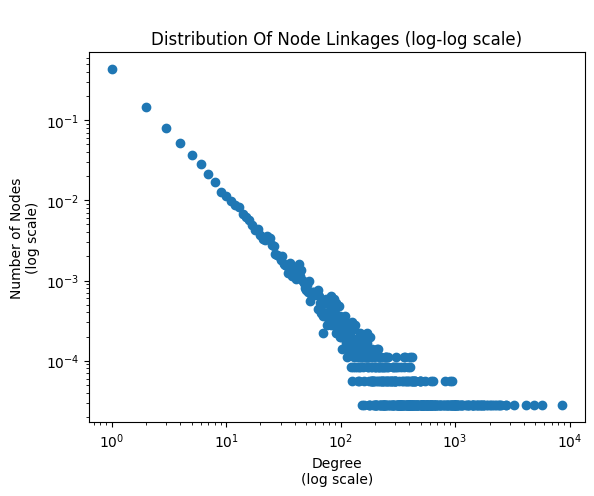

In [25]:
log(f"mGraph > Vertices: \t{mGraph.number_of_nodes():,}")
log(f"mGraph > Edges: \t{mGraph.number_of_edges():,}")

in_degree = pd.DataFrame(mGraph.in_degree(), columns=['SOURCE', 'degree'])
out_degree = pd.DataFrame(mGraph.out_degree(), columns=['SOURCE', 'degree'])

in_degree.sort_values('degree', ascending=False, inplace=True)
out_degree.sort_values('degree', ascending=False, inplace=True)

log("In degree: (Most referenced subreddits)")
print(in_degree.head(5).to_latex(index=False))

log("Out degree: (Referencing other subreddits)")
print(out_degree.head(5).to_latex(index=False))

def plot_degree_histogram(g, normalized=True):
    print("Creating histogram...")
    aux_y = nx.degree_histogram(g)
    
    aux_x = np.arange(0,len(aux_y)).tolist()
    
    n_nodes = g.number_of_nodes()
    
    if normalized:
        for i in range(len(aux_y)):
            aux_y[i] = aux_y[i]/n_nodes
    
    return aux_x, aux_y

def in_degree_plot(G):
    in_degrees = dict(G.in_degree())
    in_degree_values = list(in_degrees.values())

    # Plot the in-degree distribution
    plt.hist(in_degree_values, bins=range(0, max(in_degree_values) + 1), density=True, alpha=0.75)
    plt.xlabel('In-Degree')
    plt.ylabel('Frequency')
    plt.title('In-Degree Distribution')
    plt.grid(True)
    plt.show()

# plt.title('\nDistribution Of Node Linkages (log-log scale)')
# plt.xlabel('Degree\n(log scale)')
# plt.ylabel('Number of Nodes\n(log scale)')
# plt.xscale("log")
# plt.yscale("log")
# [aux_x, aux_y] = plot_degree_histogram(mGraph)
# plt.plot(aux_x, aux_y, 'o')
in_degree_plot(mGraph)

Calculation of centrality indices: Degree Centrality, Betweenness Centrality, Closeness Centrality and Eigenvector Centrality

In [19]:
# Calculate (In/Out)-Degree centrality (in and out degree)
total_degree = in_degree.merge(out_degree, on='SOURCE', suffixes=('_in', '_out'))
total_degree['total_degree_centrality'] = total_degree['degree_in'] + total_degree['degree_out']
total_degree_centrality = total_degree.sort_values('total_degree_centrality', ascending=False)


log("Total Degree-centrality:")
print(total_degree.head(5).to_latex(index=False))


# Prune low connectivity nodes to speed up the computation of certain properties of the graph
def prune_nodes(G):
    threshold = 300
    graph_copy = G.copy()
    nodes_to_remove = total_degree_centrality[total_degree_centrality['total_degree_centrality'] < threshold]['SOURCE'].tolist()
    graph_copy.remove_nodes_from(nodes_to_remove)
    total_nodes = graph_copy.number_of_nodes()
    total_edges = graph_copy.number_of_edges()
    print(f"Total Nodes after Pruning: {total_nodes}")
    print(f"Total Edges after Pruning: {total_edges}")
    return graph_copy

# Calculate betweenness centrality using an approximation measure for time reasons
# If we calculate betweenness centrality for k=n then it will take too much (we can use a sample of k nodes)

betweennes_calculation = nx.betweenness_centrality(mGraph, k = 100, weight = 'LINK_SENTIMENT')
betweenness_centrality = pd.DataFrame(betweennes_calculation.items(), columns=['SOURCE', 'betweenness_centrality'])

betweenness_centrality = betweenness_centrality.sort_values('betweenness_centrality', ascending=False)

log("Betweenness Centrality: (Influence of node in graph)")
print(betweenness_centrality.head(5).to_latex(index=False))


# Calculate eigenvector centrality. We need a function
# which does that for multiGraph instead of singleGraph
# Used the same start parameters (mat_iter and tol) as NetworkX
def m_eigenvector_centrality(G, max_iter=100, tol=1e-6):
    # Prune some nodes of the matrix otherwise my PC crashes!
    G_copy = prune_nodes(G)
    # Make an adjacency matrix
    adjacency_matrix = csr_matrix(nx.adjacency_matrix(G_copy))

    # Array to save eigenvector centrality for each node
    num_nodes = len(G_copy.nodes())
    eigenvector = np.full(num_nodes, 1.0 / num_nodes)

    for _ in range(max_iter):
        # Calculate the matrix-vector product
        new_eigenvector = np.dot(adjacency_matrix.toarray(), eigenvector)

        # Normalize
        norm = np.linalg.norm(new_eigenvector)
        new_eigenvector = new_eigenvector / norm

        # Repeat until convergence (or max_iter)
        if np.linalg.norm(new_eigenvector - eigenvector) < tol:
            return dict(zip(G_copy.nodes(), new_eigenvector))

        eigenvector = new_eigenvector

    return dict(zip(G_copy.nodes(), eigenvector))

eigenvector_calculation = m_eigenvector_centrality(mGraph)
eigenvector_centrality = pd.DataFrame(eigenvector_calculation.items(), columns=['SOURCE', 'eigenvector_centrality'])
eigenvector_centrality = eigenvector_centrality.sort_values('eigenvector_centrality', ascending=False)

log("Top 5 Nodes by Eigenvector Centrality:")
print(eigenvector_centrality.head(5).to_latex(index=False))

# Use a subset of nodes to calculate closeness centrality for. The subset is chosen as
# the combination of other centrality values
combined_centrality = total_degree_centrality.merge(betweenness_centrality, on='SOURCE')
combined_centrality = combined_centrality.merge(eigenvector_centrality, on='SOURCE')

# Just sum the values
combined_centrality['combined_centrality'] = (
    combined_centrality['total_degree_centrality'] +
    combined_centrality['betweenness_centrality'] +
    combined_centrality['eigenvector_centrality']
)

combined_centrality = combined_centrality.sort_values('combined_centrality', ascending=False)
# Select the top 20
top_nodes = combined_centrality.head(20)
top_nodes_list = top_nodes['SOURCE'].tolist()

closeness_centrality_calc = {}

for node in top_nodes_list:
    closeness_centrality_calc[node] = nx.closeness_centrality(mGraph, u=node)
closeness_centrality = pd.DataFrame(closeness_centrality_calc.items(), columns=['SOURCE', 'closeness_centrality'])
closeness_centrality = closeness_centrality.sort_values('closeness_centrality', ascending=False)

log("Top 5 Nodes by Closeness Centrality:")
print(closeness_centrality.head(5).to_latex(index=False))

[19:15:43] Total Degree-centrality:
\begin{tabular}{lrrr}
\toprule
        SOURCE &  degree\_in &  degree\_out &  total\_degree\_centrality \\
\midrule
     askreddit &       7329 &        1338 &                     8667 \\
          iama &       3694 &        1181 &                     4875 \\
          pics &       2779 &           4 &                     2783 \\
writingprompts &       2490 &        1707 &                     4197 \\
        videos &       2446 &           4 &                     2450 \\
\bottomrule
\end{tabular}



C:\Users\marte\AppData\Local\Temp\ipykernel_20360\1863884375.py:8: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(total_degree.head(5).to_latex(index=False))


[19:16:45] Betweenness Centrality: (Influence of node in graph)
\begin{tabular}{lr}
\toprule
         SOURCE &  betweenness\_centrality \\
\midrule
      askreddit &                0.062942 \\
 subredditdrama &                0.053255 \\
           iama &                0.039102 \\
   outoftheloop &                0.033549 \\
leagueoflegends &                0.020587 \\
\bottomrule
\end{tabular}



C:\Users\marte\AppData\Local\Temp\ipykernel_20360\1863884375.py:32: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(betweenness_centrality.head(5).to_latex(index=False))


Total Nodes after Pruning: 314
Total Edges after Pruning: 56691
[19:16:48] Top 5 Nodes by Eigenvector Centrality:


C:\Users\marte\AppData\Local\Temp\ipykernel_20360\1863884375.py:69: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(eigenvector_centrality.head(5).to_latex(index=False))


\begin{tabular}{lr}
\toprule
        SOURCE &  eigenvector\_centrality \\
\midrule
      buildapc &                0.690689 \\
   techsupport &                0.603486 \\
 buildapcforme &                0.254779 \\
     windows10 &                0.135070 \\
subredditdrama &                0.101864 \\
\bottomrule
\end{tabular}

[19:17:45] Top 5 Nodes by Closeness Centrality:
\begin{tabular}{lr}
\toprule
       SOURCE &  closeness\_centrality \\
\midrule
    askreddit &              0.313944 \\
         iama &              0.304565 \\
       videos &              0.287835 \\
         pics &              0.282841 \\
todayilearned &              0.281916 \\
\bottomrule
\end{tabular}



C:\Users\marte\AppData\Local\Temp\ipykernel_20360\1863884375.py:96: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(closeness_centrality.head(5).to_latex(index=False))


Calculation of Clustering Coefficient

In [29]:
# As before, we need to make our own function since
# networkX does not work for MultiDiGraphs
def f_clustering_coefficient(G, node):
    # Get the neighbors of the given node
    neighbors = set(G.neighbors(node))

    # If there are no neighbors then return 0
    if len(neighbors) < 2:
        return 0.0

    # Find the number of edges between neighbors
    edges_between_neighbors = 0

    for u in neighbors:
        for v in neighbors:
            if u != v and G.has_edge(u, v):
                # Usually edge weights are not considered, hence we just add +1
                edges_between_neighbors += 1

    # Calculate the clustering coefficient
    clustering_coefficient = edges_between_neighbors / (len(neighbors) * (len(neighbors) - 1))
    return clustering_coefficient


clustering_coefficient_calc = {}
for node in mGraph.nodes():
    clustering_coefficient_calc[node] = f_clustering_coefficient(mGraph, node)

clustering_coefficient = pd.DataFrame(clustering_coefficient_calc.items(), columns=['SOURCE', 'clustering_coefficient'])
count_of_ones = len(clustering_coefficient[clustering_coefficient['clustering_coefficient'] == 1])

# 1 is the highest clustering coefficient value
log("Number of nodes with a clustering coefficient = 1:")
print(count_of_ones)


[12:01:43] Number of nodes with a clustering coefficient = 1:
1498


Network Diameter + Number of Connected Components + Size of connected components + Density

In [12]:
strongly_connected_components = list(nx.strongly_connected_components(mGraph))
component_sizes = [len(component) for component in strongly_connected_components]
sorted_sizes = sorted(component_sizes, reverse=True)

log("Number of Strongly Connected Components:")
total_Scc = len(strongly_connected_components)
print(total_Scc)
log("Top 5 Strongly Connected Components by size:")
for i, size in enumerate(sorted_sizes[:5], start=1):
    print(f"Component {i}: Size = {size} nodes")

density = nx.density(mGraph)
log("The density of the Graph is")
print(density)

# Calculate diameter only for the biggest SCC
largest_scc = max(strongly_connected_components, key=len)
largest_scc_subgraph = mGraph.subgraph(largest_scc)
# diameter = nx.diameter(largest_scc_subgraph, weight="weight", usebounds=True)
diameter = approximation.diameter(largest_scc_subgraph)

log("Diameter approximation of largest SCC:")
print(diameter)

[11:07:58] Number of Strongly Connected Components:
24071
[11:07:58] Top 5 Strongly Connected Components by size:
Component 1: Size = 11564 nodes
Component 2: Size = 6 nodes
Component 3: Size = 5 nodes
Component 4: Size = 4 nodes
Component 5: Size = 4 nodes
[11:07:58] The density of the Graph is
0.00022389565198911403
[11:08:02] Diameter approximation of largest SCC:
12


Find Cliques 

In [10]:
# Convert to undirected graph. Explanation to why this is fine (https://stackoverflow.com/questions/12896477/cliques-for-directed-graphs-in-igraph)
undirected_graph = nx.Graph()

# Add an edge (u,v) in the undirected graph iff in our multidigraph we have
# (u,v) and (v,u)
for u, v in mGraph.edges():
    # Check if there is an edge (v, u) in the MultiDiGraph
    if mGraph.has_edge(v, u):
        undirected_graph.add_edge(u, v)

cliques = list(nx.find_cliques(undirected_graph))

sorted_cliques = sorted(cliques, key=lambda x: len(x), reverse=True)

# Print the 5 largest cliques
for i, clique in enumerate(sorted_cliques[:5], start=1):
    print(f"Largest Clique {i}, Length {len(clique)}: {clique}")

Largest Clique 1, Length 33: ['greenbaypackers', 'seahawks', '49ers', 'ravens', 'azcardinals', 'nfl', 'panthers', 'oaklandraiders', 'texans', 'bengals', 'colts', 'steelers', 'eagles', 'buffalobills', 'chibears', 'nfl_draft', 'falcons', 'browns', 'denverbroncos', 'cowboys', 'kansascitychiefs', 'saints', 'jaguars', 'nyjets', 'chargers', 'redskins', 'detroitlions', 'buccaneers', 'miamidolphins', 'nygiants', 'minnesotavikings', 'losangelesrams', 'patriots']
Largest Clique 2, Length 33: ['greenbaypackers', 'seahawks', '49ers', 'ravens', 'azcardinals', 'nfl', 'panthers', 'oaklandraiders', 'texans', 'bengals', 'colts', 'steelers', 'eagles', 'buffalobills', 'chibears', 'nfl_draft', 'falcons', 'browns', 'denverbroncos', 'cowboys', 'kansascitychiefs', 'saints', 'jaguars', 'nyjets', 'chargers', 'redskins', 'detroitlions', 'buccaneers', 'miamidolphins', 'nygiants', 'minnesotavikings', 'losangelesrams', 'tennesseetitans']
Largest Clique 3, Length 10: ['mbotandgtron', 'nomina', 'cqb', 'pears', 'kill

Run homophily test with NSFW and SFW subreddits (not done yet)

In [31]:
# Open the JSON file for reading
with open("subs.json", "r") as json_file:
    # Load the JSON data from the file
    data = json.load(json_file)

# Extract all the names into a list
nsfw_subs = list(data.keys())
nsfw_Graph = mGraph.copy()
# Create dictionary
nsfw_subs_dict = {name: True for name in nsfw_subs}
nsfw_count = 0
sfw_count = 0
for node in mGraph.nodes:
    if node in nsfw_subs_dict:
        nsfw_count += 1
        mGraph.nodes[node]["nsfw"] = True 
    else:
        sfw_count += 1
        mGraph.nodes[node]["nsfw"] = False  

total_nodes = nsfw_count + sfw_count
# Probability to have an edge between SFW and NSFW subreddits
edge_probability = 2*(nsfw_count/total_nodes)*(sfw_count/total_nodes)

# Calculate number of edges between SFW and NSFW
nsfw_to_sfw_edges = 0
sfw_to_nsfw_edges = 0
total_edges = 0
for edge in mGraph.edges:
    total_edges += 1
    source_node, target_node, _ = edge

    # Check the "nsfw" attribute of the source and target nodes
    source_nsfw = mGraph.nodes[source_node].get("nsfw", False)
    target_nsfw = mGraph.nodes[target_node].get("nsfw", False)

    # Count the edge based on the node attributes
    if source_nsfw and not target_nsfw:
        nsfw_to_sfw_edges += 1
    elif not source_nsfw and target_nsfw:
        sfw_to_nsfw_edges += 1

nsfw_to_sfw_ratio = (nsfw_to_sfw_edges + sfw_to_nsfw_edges)/total_edges

# Basically the ratio of number of NSFW-SFW edges to the expected number of those.
# The lower the ratio the higher homophily between the groups
log("Homophily 'score':")
print(nsfw_to_sfw_ratio/edge_probability)

[13:52:00] Homophily 'score':
0.7263466594893151


Important nodes acting as Bridges. Calculation for MultiDiGraph (Paper: https://core.ac.uk/reader/82453490) 

In [27]:
# We say that a bridge in a Graph is a strong bridge if removing it
# increases the number of SCC (ref: paper above)

def find_bridges(G):
    bridges = []

    total_scc = len(list(nx.strongly_connected_components(G)))
    graph_copy = G.copy()
    count = 0
    for u, v in G.edges():
        if count % 5000 == 0:
            print(f"Processed {count} edges")
        count += 1
        # Temporarily remove the edge (u, v)
        graph_copy.remove_edge(u, v)
        new_scc_count = len(list(nx.strongly_connected_components(graph_copy)))

        # If the number of new SCC < original SCC then the edge is bridge
        if new_scc_count > total_scc:
            bridges.append((u, v))

        # Restore edge (u, v)
        graph_copy.add_edge(u, v)
    return bridges

# Find bridge edges in the undirected graph
bridge_edges = list(find_bridges(prune_nodes(mGraph)))
print(bridge_edges)
bridge_nodes = [node for edge in bridge_edges for node in edge]

# Count the occurrences of each node
top_nodes = Counter(bridge_nodes)

# Get the top 5 nodes with the highest counts
top_nodes = top_nodes.most_common(5)

# Print the top 5 nodes
print("Top 5 Nodes in Bridge Edges:")
for node, count in top_nodes:
    print(f"Node: {node}, Count: {count}")

Total Nodes after Pruning: 314
Total Edges after Pruning: 56691
Processed 0 edges
Processed 5000 edges
Processed 10000 edges
Processed 15000 edges
Processed 20000 edges
Processed 25000 edges
Processed 30000 edges
Processed 35000 edges
Processed 40000 edges
Processed 45000 edges
Processed 50000 edges
Processed 55000 edges
[('footballhighlights', 'soccer'), ('gifs', 'resissues'), ('pics', 'changelog'), ('ironthronepowers', 'bugs'), ('modelusgov', 'mhoc')]
Top 5 Nodes in Bridge Edges:
Node: footballhighlights, Count: 1
Node: soccer, Count: 1
Node: gifs, Count: 1
Node: resissues, Count: 1
Node: pics, Count: 1


Important nodes acting as Bridges. Calculation for Undirected graph

In [28]:
simple_graph = mGraph.to_undirected()

# Find bridge edges in the undirected graph
bridge_edges = list(nx.bridges(simple_graph))

bridge_nodes = [node for edge in bridge_edges for node in edge]

# Count the occurrences of each node
top_nodes = Counter(bridge_nodes)

# Get the top 5 nodes with the highest counts
top_nodes = top_nodes.most_common(5)

# Print the top 5 nodes
print("Top 5 Nodes in Bridge Edges (undirected graphs):")
for node, count in top_nodes:
    print(f"Node: {node}, Count: {count}")

Top 5 Nodes in Bridge Edges (undirected graphs):
Node: askreddit, Count: 291
Node: writingprompts, Count: 188
Node: tipofmypenis, Count: 188
Node: iama, Count: 183
Node: mhoc, Count: 133


Implement Louvain (alternative to Girvan-Newman) algorithm 

In [37]:
# Louvain algorithm is more time efficient thant Girvan Newman
result = nx.community.louvain_communities(mGraph, weight = 'LINK_SENTIMENT')

community_sizes = [(community, len(community)) for community in result]

# Sort communities by size in descending order
sorted_communities = sorted(community_sizes, key=lambda x: x[1], reverse=True)

log("Top 5 communities by size identified by Louvain method:")
# Print the 5 largest communities along with their sizes
for i, (community, size) in enumerate(sorted_communities[:5], start=1):
    print(f"Community {i}: Size = {size}")
    print(f"   Nodes: {community}")

[15:03:32] Top 5 communities by size identified by Louvain method:
Community 1: Size = 4081
   Nodes: {'captainhair59', 'scihi', 'askscience', 'hiredgoonz', 'velabasstuff', 'thedynastyproject', 'camerasbeingbros', 'titlebitching', 'jukmifgguggh', 'lammy', 'thoughtfactory', 'coloringcorruptions', 'shooting_stars', 'peoplelinkingtosubs', 'ideasfortifu', 'myexgirlfriend', 'crappydesign', 'linguistics', 'drawmynightmare', 'storiesfromsilhouette', 'controllablewebcams', 'labrats', 'avitus', 'curiousvideos', 'ghotioninabarrel', 'asmr', 'benedictcumberbatch', 'petnames', 'cringepics', 'birthdaybuds', 'ytpl', 'messingwithreporters', 'aircrack', 'secretsubgonewild', 'ringtones', 'thenauticaltroupe', 'infrastructureporn', 'tributeme', 'alcoholism_medication', 'allisforgiven', 'fakehistory', 'hahayeah', 'thedearhunter', 'westies', 'lurkershares', 'white_lupin', 'adviceanimals', 'parallelview', 'theculture', 'racisttwitterhumor', 'highqualitygifs', 'hoedown', 'cringe', 'chardeemacdennis', 'sebasti

## Visualisations
Visualisations help understanding how a network is situated.

In [20]:
pos = nx.spring_layout(mGraph)  # Layout algorithm, e.g., spring_layout
node_colors = [node[1]['color'] for node in mGraph.nodes(data=True)]

nx.draw(G, pos, with_labels=True, node_size=500, node_color=node_colors)
plt.show()

KeyboardInterrupt: 